In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import rotate, gaussian_filter
from PIL import Image
from ipywidgets import interact, IntSlider, FloatLogSlider
from numpy.fft import fft2, ifft2, fftshift
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [2]:
class ARPESImageLoader:
    def __init__(self, condition, basepath, parentfolder, basename, basename2, ext, n_files):
        # Convert condition from string to float where 'p' indicates the decimal point
        self.energy = float(condition.replace('p', '.'))
        # Construct the file path for the given condition
        condition_str = condition
        image_path = f"{basepath}{parentfolder}{basename}{condition_str}{basename2}{str(n_files).zfill(3)}{ext}"
        #image_path = 
        # Load and store the image
        self.image = np.array(Image.open(image_path))
        self.nobackground = []

In [3]:
# /Users/alexpoulin/Library/CloudStorage/OneDrive-NortheasternUniversity/DeLTA Lab/data/ARPES Ag(111) 06272024
# # Example usage:
basepath = '/Users/alexpoulin/Library/CloudStorage/OneDrive-NortheasternUniversity/ARPES data deconvolution/path'
basename = '/ARPES_Ag_Ekin'
energies = ['20p0', '20p5', '21p0', '21p3', '21p22', '21p87', '22p37', 
              '22p87', '23p09', '23p40', '23p52', '24p5', '25p0']
parentfolder = '/ARPES_Ag_Ekinslices_He5p5m2_100mA_all'
basename2 = '_He5p5m2_100mA_AV_'
ext = '.TIF'
n_files = 1

# Create a list of ARPESImageLoader objects, one for each condition
arpes_loaders_5p5_100mA = [ARPESImageLoader(energy, basepath, parentfolder, basename, basename2, ext, n_files) for energy in energies]

In [4]:
energies = ['20p0', '20p5', '21p0', '21p3', '21p22', '21p87', '22p37', 
              '22p87', '23p09', '23p40', '23p52', '24p5', '25p0']
parentfolder = '/ARPES_Ag_Ekinslices_He8p3m2_35mA_all'
basename2 = '_He8p3m2_35mA_AV_'
arpes_loaders_8p3_35mA = [ARPESImageLoader(energy, basepath, parentfolder, basename, basename2, ext, n_files) for energy in energies]

In [5]:
energies = ['20p0', '20p5', '21p0', '21p3', '21p22', '21p87', '22p37', 
              '22p87', '23p09', '23p40', '23p52', '24p5', '25p0']
parentfolder = '/ARPES_Ag_Ekinslices_He6p5m2_100mA_all'
basename3 = '_He6p5m2_100mA_AV_'
arpes_loaders_6p5_100mA = [ARPESImageLoader(energy, basepath, parentfolder, basename, basename3, ext, n_files) for energy in energies]


In [6]:
energies = ['20p0', '20p5', '21p0', '21p3', '21p22', '21p87', '22p37', 
              '22p87', '23p09', '23p40', '23p52', '24p5', '25p0']
parentfolder = '/ARPES_Ag_Ekinslices_He6p0m2_120mA_all'
basename4 = '_He6p0m2_120mA_AV_'
arpes_loaders_6p0_120mA = [ARPESImageLoader(energy, basepath, parentfolder, basename, basename4, ext, n_files) for energy in energies]

In [7]:
en = np.asarray([ar.energy for ar in arpes_loaders_5p5_100mA])
conditions = [arpes_loaders_5p5_100mA,arpes_loaders_6p5_100mA,arpes_loaders_6p0_120mA,arpes_loaders_8p3_35mA,]
energy = 23.4
index = np.where(energy==en)[0][0]
pixels = np.zeros((1024,1024,len(en),len(conditions)),dtype = int)
for k,energy in enumerate(en):
    for l,con in enumerate(conditions):
                pixels[:,:,k,l] = con[k].image

In [8]:
# Prepare to store cluster labels
num_energies = len(en)
num_conditions = len(conditions)
labels = np.zeros((1024, 1024,num_energies), dtype=int)
num_pixels = 1024 * 1024
num_clusters =  6
for k in range(len(en)):
    print(f"Processing energy level {k + 1}/{num_energies}")
    
    # Extract data at energy level k
    data_at_energy = pixels[:, :, k, :]  # Shape: (1024, 1024, 5)
    
    # Reshape data to (num_pixels, num_conditions)
    data_reshaped = data_at_energy.reshape(num_pixels, num_conditions)
    
    # Standardize the features
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data_reshaped)
    
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data_standardized)

    '''
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data_standardized)
    labels_at_energy = kmeans.labels_
    '''
    
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42) 
    # gmm.fit(X_pca)
    # gmmLabels = gmm.predict(X_pca)
    gmmLabels = gmm.fit_predict(X_pca)
    labels_at_energy = gmmLabels 
    
    '''
    GaussianMixture(n_components=3)
    gmm.fit(X)
    labels = gmm.predict(X)
    '''
    
    # Get cluster labels
    labels[:, :, k] = labels_at_energy.reshape(1024, 1024)

Processing energy level 1/13
Processing energy level 2/13
Processing energy level 3/13
Processing energy level 4/13
Processing energy level 5/13
Processing energy level 6/13
Processing energy level 7/13
Processing energy level 8/13
Processing energy level 9/13
Processing energy level 10/13
Processing energy level 11/13
Processing energy level 12/13
Processing energy level 13/13


In [9]:
from matplotlib.colors import ListedColormap

energy_level = 4
# Generate a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# If num_clusters exceeds the number of predefined colors, repeat the colors
if num_clusters > len(colors):
    colors = colors * (num_clusters // len(colors) + 1)

# Create a colormap with the number of clusters
cmap = ListedColormap(colors[:num_clusters])

In [10]:
print(pixels[:,:,2].shape)
print(np.max(pixels[:,:,2]))    

(1024, 1024, 4)
2820


(1024, 1024)


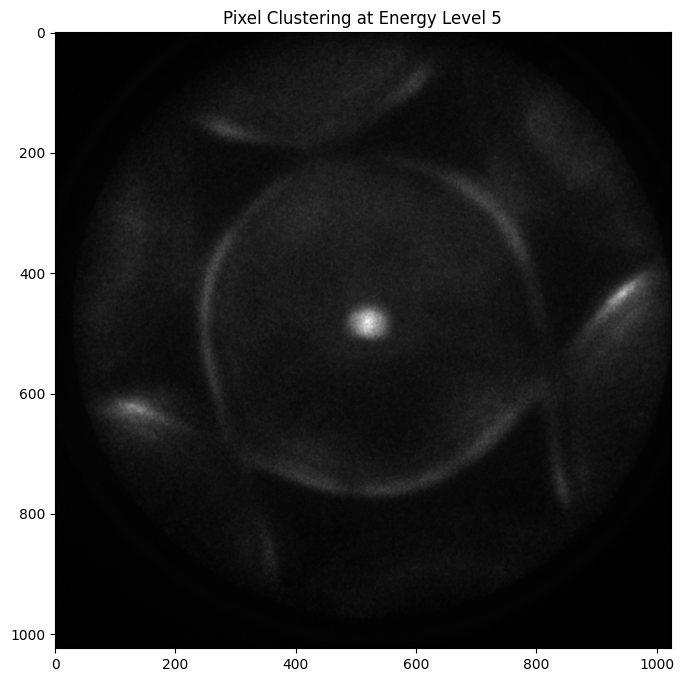

In [11]:
# Plotting remains the same
plt.figure(figsize=(8, 8))

#set image to be the image at the energy level with shape [1024, 1024]
image = pixels[:, :, energy_level, 0] #pixels by pixels, by energy, by kmeancluster

print(image.shape)
#plt.imshow(labels[:, :, energy_level], cmap=cmap, vmin=0, vmax=num_clusters - 1)
plt.imshow(image, cmap='gray')
#plt.colorbar(ticks=range(num_clusters))
plt.title(f'Pixel Clustering at Energy Level {energy_level + 1}')
plt.show()

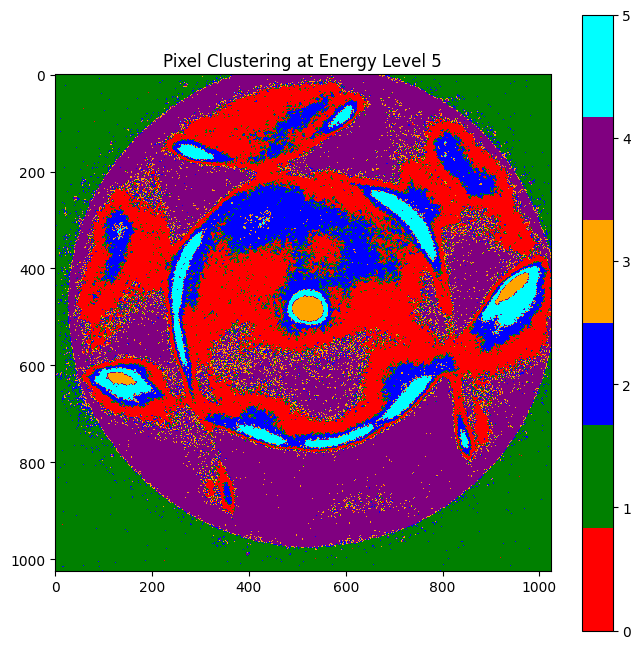

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(labels[:, :, energy_level], cmap=cmap, vmin=0, vmax=num_clusters - 1)
#plt.imshow(pixels[:, :, energy_level])
plt.colorbar(ticks=range(num_clusters))
plt.title(f'Pixel Clustering at Energy Level {energy_level + 1}')
plt.show()

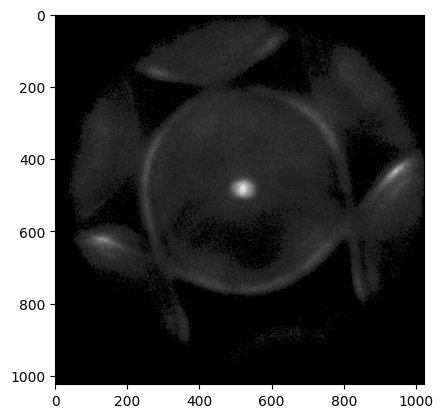

In [50]:
alteredPixels = np.copy(pixels)

for i in range(1024):
    for j in range(1024):
        if labels[i,j,energy_level]==1 or labels[i,j,energy_level]==4:
            alteredPixels[i,j,energy_level,0]=0

plt.imshow(alteredPixels[:, :, energy_level,0], cmap='gray')#, vmin=0,vmax=80)

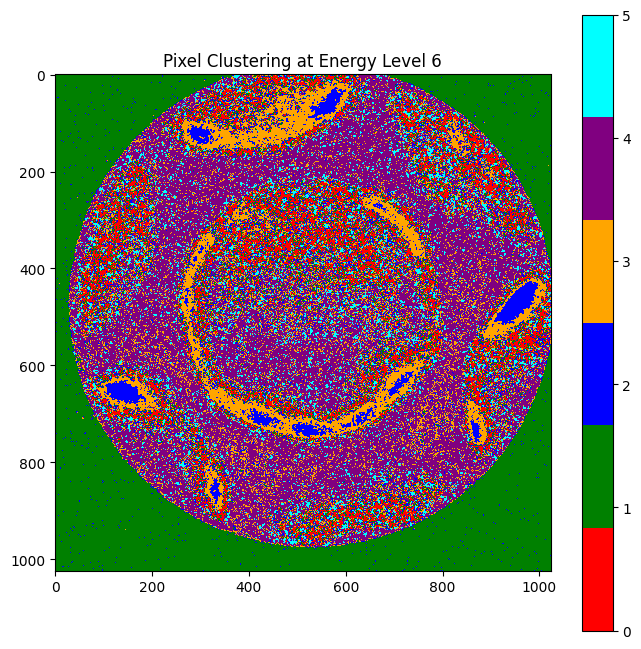

In [52]:
#do now for energy level 3
energy_level = 5
plt.figure(figsize=(8, 8))
plt.imshow(labels[:, :, energy_level], cmap=cmap, vmin=0, vmax=num_clusters - 1)
plt.colorbar(ticks=range(num_clusters))
plt.title(f'Pixel Clustering at Energy Level {energy_level + 1}')
plt.show()


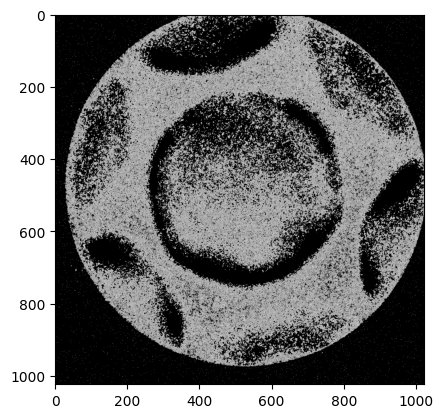

In [53]:
alterPixels = np.copy(pixels)
for i in range(1024):
    for j in range(1024):
        if labels[i,j,energy_level]==1 or labels[i,j,energy_level]==0 or labels[i,j,energy_level]==2 or labels[i,j,energy_level]==3:
            alterPixels[i,j,energy_level,0]=0

plt.imshow(alterPixels[:, :, energy_level,0], cmap='gray')#, vmin=0,vmax=80)

In [28]:
data_reshaped = pixels.reshape(num_pixels, num_energies, num_conditions)
num_clusters = 6  # Adjust as needed
# Compute statistical features across energies
mean_intensity = data_reshaped.mean(axis=1)       # Shape: (num_pixels, 5)
std_intensity = data_reshaped.std(axis=1)         # Shape: (num_pixels, 5)
median_intensity = np.median(data_reshaped, axis=1)  # Shape: (num_pixels, 5)

# Prepare to store cluster labels
labels = np.zeros((1024, 1024, num_energies), dtype=int)

for k in range(num_energies):
    print(f"Processing energy level {k + 1}/{num_energies}")
    
    neighboring_energies = []
    if k > 0:
        neighboring_energies.append(k - 1)
    if k < num_energies - 1:
        neighboring_energies.append(k + 1)
    
    # Feature components
    features_list = []
    
    # Intensities at energy k
    features_list.append(data_reshaped[:, k, :])  # (num_pixels, 5)
    
    # Intensities at neighboring energies
    for n in neighboring_energies:
        features_list.append(data_reshaped[:, n, :])  # (num_pixels, 5)
    
    # Statistical features
    features_list.append(mean_intensity)
    features_list.append(std_intensity)
    features_list.append(median_intensity)
    
    # Intensity differences between conditions at energy k
    intensity_k = data_reshaped[:, k, :]  # (num_pixels, 5)
    differences = []
    for i in range(num_conditions):
        for j in range(i + 1, num_conditions):
            diff = intensity_k[:, i] - intensity_k[:, j]
            differences.append(diff.reshape(-1, 1))
    differences = np.hstack(differences)  # Shape: (num_pixels, 10)
    features_list.append(differences)
    
    # Combine all features
    features = np.hstack(features_list)
    
    # Standardize features
    scaler = StandardScaler()
    features_standardized = scaler.fit_transform(features)
    
    # Clustering

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(features_standardized)
    
    # Assign labels
    labels_flat = kmeans.labels_
    labels[:, :, k] = labels_flat.reshape(1024, 1024)


Processing energy level 1/13
Processing energy level 2/13
Processing energy level 3/13
Processing energy level 4/13
Processing energy level 5/13
Processing energy level 6/13
Processing energy level 7/13
Processing energy level 8/13
Processing energy level 9/13
Processing energy level 10/13
Processing energy level 11/13
Processing energy level 12/13
Processing energy level 13/13


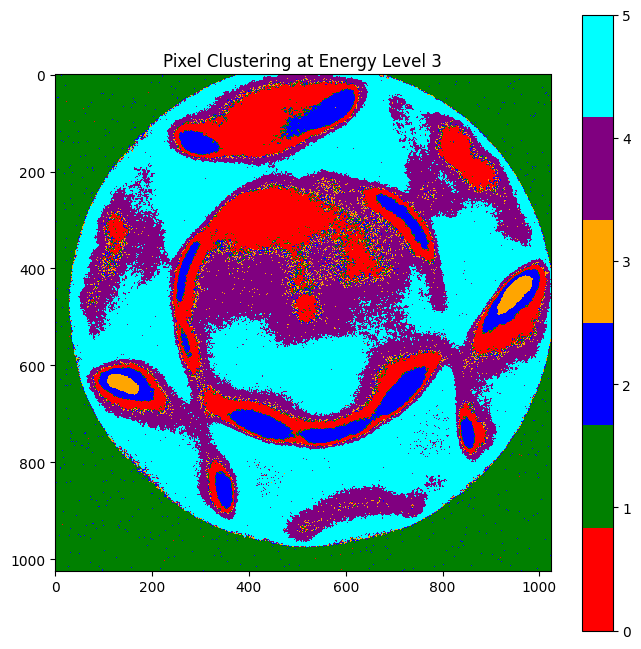

In [29]:
energy_level = 2
# Generate a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# If num_clusters exceeds the number of predefined colors, repeat the colors
if num_clusters > len(colors):
    colors = colors * (num_clusters // len(colors) + 1)

# Create a colormap with the number of clusters
cmap = ListedColormap(colors[:num_clusters])

# Plotting remains the same
plt.figure(figsize=(8, 8))
plt.imshow(labels[:, :, energy_level], cmap=cmap, vmin=0, vmax=num_clusters - 1)
plt.colorbar(ticks=range(num_clusters))
plt.title(f'Pixel Clustering at Energy Level {energy_level + 1}')
plt.show()

In [15]:
plt.figure(figsize=(, 8))
plt.imshow(pixels[:, :, energy_level,0],vmin=0,vmax=100)

SyntaxError: invalid syntax (1292112404.py, line 1)